# How does transfer learning impact neural networks?

**Autorzy**: Adam Klekowski, Paweł Kruczkiewicz, Piotr Makarewicz


Transfer learning to technika, w której model uczenia maszynowego wykorzystuje wiedzę i umiejętności nabyte na jednym zadaniu do rozwiązania innego, pokrewnego zadania. Fine-tuning to proces dostosowywania modelu nauczonego przy użyciu transfer learningu, poprzez dostosowanie kilku ostatnich warstw do konkretnej domeny lub problemu, w celu uzyskania lepszej wydajności na konkretnym zadaniu. Stosuje się je, aby przyspieszyć proces uczenia, wykorzystać wiedzę z dużych zbiorów danych lub zamodelować złożone relacje, gdy nie ma wystarczającej ilości danych do pełnego treningu modelu od podstaw.

## Przygotowanie
### Import bibliotek

In [15]:
import os
import time
import shutil
import random

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs Available:  1


### Funkcje pomocnicze

In [3]:
## consts
DATA_FOLDER="data-trimmed"

INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 32

In [4]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def plot_train_results(history, times, title):
    h = history.history
    loss, acc, val_loss, val_acc = h["loss"], h["categorical_accuracy"], h["val_loss"], h["val_categorical_accuracy"]
    avg_epoch_time = np.round(np.mean(times), 1)
    x = np.arange(len(loss)) + 1

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f"{title} [Avg epoch time: {avg_epoch_time} s]")

    ax1.set_title("accuracy")
    ax1.plot(x, acc, label="Test")
    ax1.plot(x, val_acc, label="Validation")
    ax1.set_ylim([0, 1])
    ax1.legend()

    ax2.set_title("loss")
    ax2.plot(x, loss, label="Test")
    ax2.plot(x, val_loss, label="Validation")
    ax2.set_ylim([0, 5])
    ax2.legend()

### Pobranie i przygotowanie zbioru

Wybraliśmy zbiór Food-101, który zawiera zdjęcia 101 różnych rodzajów jedzenia. Z tego zbiory wybraliśmy 20 klas i z każdej klasy wzięlismy 256 próbek.

In [ ]:
! wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
! tar xzvf food-101.tar.gz
! mv food-101 data & rm food-101.tar.gz

In [6]:
SAMPLES_PER_CLASS = 256
OLD_FOLDER = "data/images"
NEW_FOLDER = "data-trimmed"
CHOSEN_CLASSES = {'apple_pie', 'pizza', 'hamburger', 'spaghetti_bolognese', 'chocolate_cake', 'hot_dog', 'ice_cream',
                  'carrot_cake', 'chicken_curry', 'churros', 'falafel', 'fish_and_chips', 'french_fries', 'hummus',
                  'greek_salad', 'panna_cotta', 'nachos', 'lasagna', 'tacos', 'risotto'}
NUM_CLASSES = len(CHOSEN_CLASSES)

print(f'There are {NUM_CLASSES} chosen classes: {CHOSEN_CLASSES}')

if not os.path.exists(NEW_FOLDER):
    os.mkdir(NEW_FOLDER)

for class_label in CHOSEN_CLASSES:
    old_class_dir = f"{OLD_FOLDER}/{class_label}"
    new_class_dir = f"{NEW_FOLDER}/{class_label}"

    if not os.path.exists(new_class_dir):
        os.mkdir(new_class_dir)
        # print(f"Creating {new_class_dir}")

    list_of_samples = os.listdir(old_class_dir)
    trimmed_samples = random.sample(list_of_samples, SAMPLES_PER_CLASS)
    # print(f"Number of samples: {len(trimmed_samples)}")

    for sample_name in trimmed_samples:
        shutil.copyfile(f"{old_class_dir}/{sample_name}", f"{new_class_dir}/{sample_name}")
        # print(f"Copying {sample_name} to {new_class_dir}")

There are 20 chosen classes: {'ice_cream', 'lasagna', 'spaghetti_bolognese', 'churros', 'chocolate_cake', 'falafel', 'tacos', 'fish_and_chips', 'greek_salad', 'chicken_curry', 'risotto', 'pizza', 'hummus', 'nachos', 'hot_dog', 'carrot_cake', 'apple_pie', 'french_fries', 'panna_cotta', 'hamburger'}


### Importing data

In [7]:
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=DATA_FOLDER,
    label_mode='categorical',
    image_size=(256, 256),
    validation_split=0.2,
    subset="both",
    seed=21)

Found 5120 files belonging to 20 classes.
Using 4096 files for training.
Using 1024 files for validation.


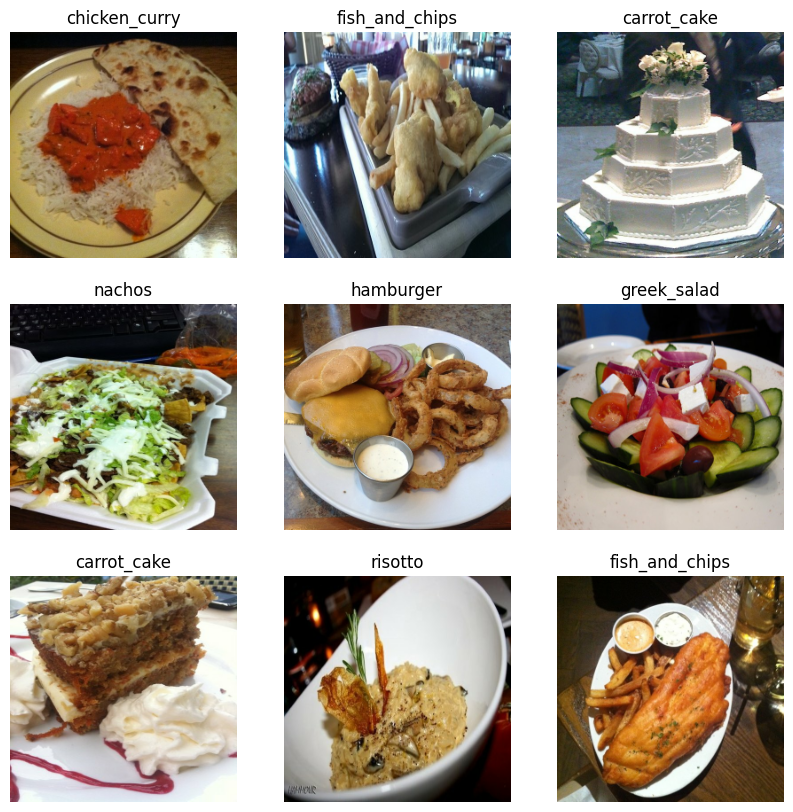

In [8]:
labels = sorted(os.listdir(DATA_FOLDER))

plt.figure(figsize=(10,10))

for (batch_of_images, batch_of_labels) in train_ds.take(1):
    batch_of_images = batch_of_images[:9]
    batch_of_labels = batch_of_labels[:9]
    for i, (image, inferred_label) in enumerate(zip(batch_of_images, batch_of_labels)):
        image = image / 255
        label = labels[np.nonzero(np.array(inferred_label))[0][0]]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")

## EfficientNetV2B0

### Użycie  EfficientNetV2B0
Jako model wykorzystaliśmy model EfficientNet wytrenowany na zbiorze ImageNet.

In [9]:
efficient_net = keras.applications.EfficientNetV2B0(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False,
    include_preprocessing=False)  # Do not include the ImageNet classifier at the top.

efficient_net.summary()

24274472/24274472 [==============================] - 0s 0us/step
Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 32  128         ['stem_conv[0][0]']              
                 

## Transfer learning

### Budowa modelu

In [10]:
DROPOUT_RATE = 0.6
L1_PENALTY = 1e-5
L2_PENALTY = 1e-5

def create_transferred_model(base_model):
    base_model.trainable = False  # Freezing the base model

    inputs = keras.Input(shape=(256, 256, 3),
                         batch_size=BATCH_SIZE)
    scaled = keras.layers.Rescaling(scale=1./255.)(inputs)

    x_base = base_model(scaled, training=False)
    gap_layer = keras.layers.GlobalAveragePooling2D()(x_base)

    dropout_layer = keras.layers.Dropout(DROPOUT_RATE)(gap_layer)

    outputs = keras.layers.Dense(NUM_CLASSES,
                                 activation="softmax",
                                 kernel_regularizer=keras.regularizers.L1L2(l1=L1_PENALTY, l2=L2_PENALTY),
                                 )(dropout_layer)
    return keras.models.Model(inputs, outputs)

W pretrenowanym modelu zamrażamy oryginalne warstwy, by nie były one modyfikowane w czasie treningu. Dodajemy warstwy, które pozwolą nam wykorzystać go do klasyfikacji obrazków z wybranych przez nas klas jedzenia

Na wejściu sieci:
 - warstwa `Input`, przyjmująca batche z obrazami o wymiarach $256 \times 256$ w trzech kolorach
 - warstwa `Rescaling`, mapująca wartości liczbowe z przedziału $[0, 255]$ na $[0,1]$

Na wyjściu sieci:
 - warstwa `GlobalAveragePooling2D`, która agreguje informacje przestrzenne w każdym kanale do jednej wartości na kanał
 - warstwa `Dropout`, która w czasie treningu zeruje losowo wyjścia części neuronów, wymuszając na kolejnej warstwie uczenie się z jak największej ilości wartości wejściowych
 - warstwa `Dense` z 20 wartościami wyjściowymi i aktywacją softmax, która zwraca wyznaczone przez sieć prawdopodobieństwa, że przykład na wejściu należy do odpowiednich klas. Dodajemy do niej dodatkowe parametry z regularyzacją L1L2. Sprawia to, że w czasie treningu do funkcji kosztu dodana jest kara na sieć za ustalanie zbyt dużych wag według norm L1 i L2.


W pierwszych próbach transfer learningu nie używaliśmy warstwy `Dropout` ani regularyzacji L1L2, skutkiem czego dochodziło do overfittingu, co widać na wykresie precyzji i funkcji kosztu podczas fine-tuningu. Model dopasował się świetnie do zbioru treningowego, uzyskując 100% dokładności, ale na zbiorze walidacyjnym jego dokładność nie przekraczała 57%, nawet po fine-tuningu.

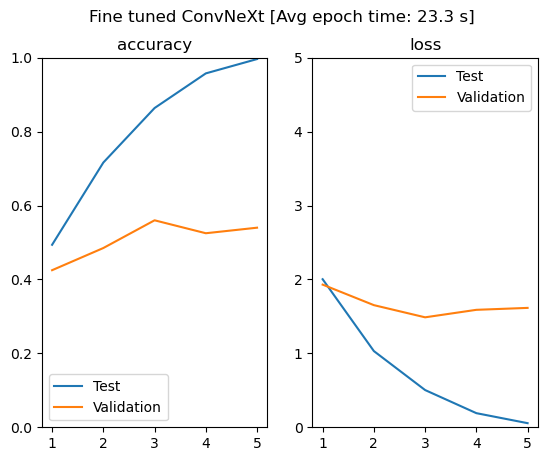

In [11]:
transferred_model = create_transferred_model(efficient_net)
transferred_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(32, 256, 256, 3)]       0         
                                                                 
 rescaling (Rescaling)       (32, 256, 256, 3)         0         
                                                                 
 efficientnetv2-b0 (Function  (None, 8, 8, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (32, 1280)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (32, 1280)                0         
                                                                 
 dense (Dense)               (32, 20)                  25620 

## Niewytrenowany model do transfer learningu


In [12]:
without_training = transferred_model
without_training.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[keras.metrics.CategoricalAccuracy()])
without_training.evaluate(validation_ds)

32/32 [==============================] - 12s 77ms/step - loss: 3.1183 - categorical_accuracy: 0.0352


[3.118260383605957, 0.03515625]

Niewytrenowany model do transfer learningu wykazuje precyzję na poziomie 0.03.

## Metoda treningu

In [ ]:
def train_and_check_model(model, model_name, t_ds, v_ds, epochs=150, lr_scale=1):
    """Trains the model and plots training results"""
    time_history = TimeHistory()

    model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.001*lr_scale),
                  loss="categorical_crossentropy", metrics=[keras.metrics.CategoricalAccuracy()])
    history = model.fit(t_ds,
                    validation_data=v_ds,
                    batch_size=BATCH_SIZE,
                    epochs=epochs,
                    callbacks=[time_history])

    model.save(f"./models/{model_name}")
    plot_train_results(history, time_history.times, model_name)

Do treningu używamy optymalizatora Nadam, który jest wariantem algorytmu Adam z interpretacją pędu według metody Nesterowa. Adam i Nadam są popularnymi, uniwersalnymi metodami, które radzą sobie dobrze w większości problemów optymalizacyjnych.

Jako funkcji kosztu używamy entropii krzyżowej, która jest standardowo wykorzystywana przy trenowaniu sieci pod kątem klasyfikacji.

Epoch 1/100
128/128 [==============================] - 23s 111ms/step - loss: 2.9732 - categorical_accuracy: 0.1064 - val_loss: 2.5579 - val_categorical_accuracy: 0.3574
Epoch 2/100
128/128 [==============================] - 14s 102ms/step - loss: 2.4726 - categorical_accuracy: 0.2827 - val_loss: 2.1727 - val_categorical_accuracy: 0.5088
Epoch 3/100
128/128 [==============================] - 13s 101ms/step - loss: 2.1316 - categorical_accuracy: 0.4016 - val_loss: 1.9176 - val_categorical_accuracy: 0.5674
Epoch 4/100
128/128 [==============================] - 13s 100ms/step - loss: 1.9076 - categorical_accuracy: 0.4697 - val_loss: 1.7433 - val_categorical_accuracy: 0.5879
Epoch 5/100
128/128 [==============================] - 14s 103ms/step - loss: 1.7407 - categorical_accuracy: 0.5168 - val_loss: 1.6189 - val_categorical_accuracy: 0.6094
Epoch 6/100
128/128 [==============================] - 13s 99ms/step - loss: 1.6277 - categorical_accuracy: 0.5547 - val_loss: 1.5245 - val_categorica

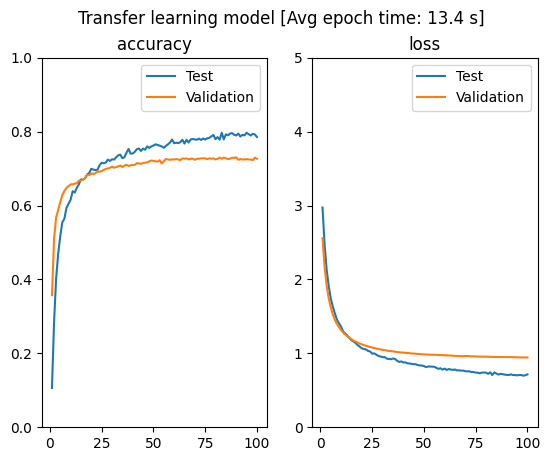

In [13]:
train_and_check_model(transferred_model, "Transfer learning model", t_ds=train_ds, v_ds=validation_ds, epochs=100, lr_scale=0.2)

In [18]:
transferred_model.evaluate(validation_ds)

32/32 [==============================] - 2s 75ms/step - loss: 0.9444 - categorical_accuracy: 0.7266


[0.944395899772644, 0.7265625]

Widzimy, że dzięki zastosowaniu regularyzacji, overfitting ma znacznie mniejszą skalę, a precyzja na zbiorze walidacyjnym osiąga 72.6%

1/1 [==============================] - 0s 38ms/step


<Axes: >

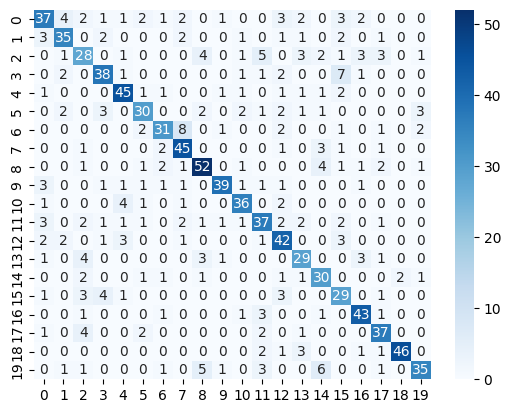

In [19]:
predictions = np.array([])
labels =  np.array([])
for x, y in validation_ds:
  predictions = np.concatenate([predictions, np.argmax(transferred_model.predict(x), axis=-1)])
  labels = np.concatenate([labels, np.argmax(y, axis=-1)])

cf_matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
sns.heatmap(cf_matrix,
            annot=True,
            cmap='Blues')

## Fine tuning
Następnie zastosowaliśmy fine-tuning. Pozwoliliśmy na modyfikację wag w bazowym modelu i uruchomiliśmy trening na 10 epok. Pozwoliło to na zwiększenie precyzji do 0.77.

Epoch 1/10
128/128 [==============================] - 131s 311ms/step - loss: 0.6556 - categorical_accuracy: 0.8018 - val_loss: 0.8422 - val_categorical_accuracy: 0.7617
Epoch 2/10
128/128 [==============================] - 37s 287ms/step - loss: 0.5766 - categorical_accuracy: 0.8347 - val_loss: 0.8179 - val_categorical_accuracy: 0.7656
Epoch 3/10
128/128 [==============================] - 37s 286ms/step - loss: 0.5398 - categorical_accuracy: 0.8396 - val_loss: 0.7928 - val_categorical_accuracy: 0.7715
Epoch 4/10
128/128 [==============================] - 37s 285ms/step - loss: 0.5003 - categorical_accuracy: 0.8499 - val_loss: 0.7888 - val_categorical_accuracy: 0.7725
Epoch 5/10
128/128 [==============================] - 37s 286ms/step - loss: 0.4679 - categorical_accuracy: 0.8640 - val_loss: 0.7819 - val_categorical_accuracy: 0.7734
Epoch 6/10
128/128 [==============================] - 37s 286ms/step - loss: 0.4522 - categorical_accuracy: 0.8735 - val_loss: 0.7674 - val_categorical_ac

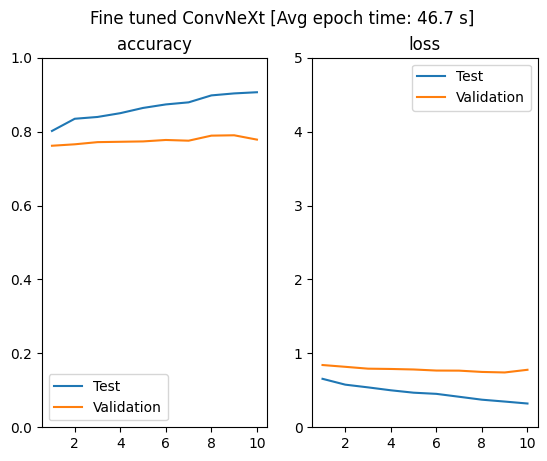

In [20]:
def fine_tune(model_after_transfer_learning):
    base_model_idx = 2
    base_model = model_after_transfer_learning.get_layer(index=base_model_idx)
    base_model.trainable = True

    train_and_check_model(model_after_transfer_learning,
                          "Fine tuned ConvNeXt",
                          t_ds=train_ds,
                          v_ds=validation_ds,
                          epochs=10, lr_scale=0.01)
fine_tune(transferred_model)

1/1 [==============================] - 0s 39ms/step


<Axes: >

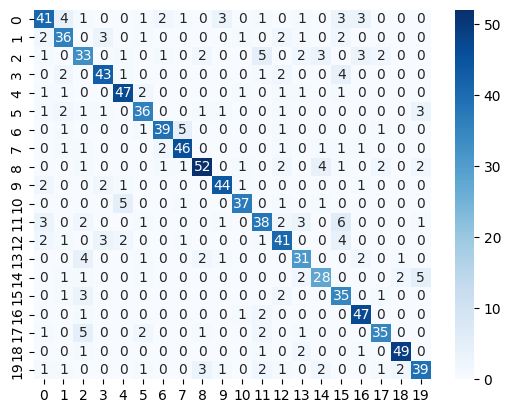

In [21]:
transferred_model.evaluate(validation_ds)

predictions = np.array([])
labels =  np.array([])
for x, y in validation_ds:
  predictions = np.concatenate([predictions, np.argmax(transferred_model.predict(x), axis=-1)])
  labels = np.concatenate([labels, np.argmax(y, axis=-1)])

cf_matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
sns.heatmap(cf_matrix,
            annot=True,
            cmap='Blues')

## Wnioski

Transfer learning pozwala na szybkie uczenie, co pozwala zaoszczędzić czas i zasoby, ponieważ wykorzystuje wstępnie wytrenowane modele, które nauczyły się reprezentacji danych na dużych zbiorach danych. Dzięki temu można uniknąć konieczności uczenia modelu od zera, co jest czasochłonne i wymaga dużej mocy obliczeniowej. Ponadto, przeniesienie wiedzy z wstępnie wytrenowanych modeli pozwala na osiągnięcie lepszych wyników na mniejszych zbiorach danych. Dzięki temu nawet w przypadku ograniczonej ilości dostępnych danych, można uzyskać skuteczne modele klasyfikacji. W naszym przykładzie każda klasa miała tylko 256 przykładów uczących, a za pomocą transfer learningu bez fine tuningu udało się uzyskać dokładność na poziomie 72.6%

Z kolei fine-tuning pozwala na aktualizację parametrów oryginalnego modelu na nowych danych, co umożliwia lepszą adaptację modelu do specyficznych warunków i zmian w danych wejściowych. W naszym przypadku podniosło to dokładność klasyfikacji do 77.8%.